In [460]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.append("../")
import matplotlib.pyplot as plt
from curve_models import NLLS, NLLS_w, NLLS_rse, power_law, CurveModel, linearized_power_law

def calc_pct(pred_best, pred_worst, pred_curr):
    return (pred_worst - pred_curr)/(pred_worst - pred_best)

dataset_titles = {'gl': 'GoogleLocal-L', 'gl-tiny': 'GoogleLocal-S', 'ml-20m-tiny': 'MovieLens-S',
                 'ml-20m-uniform': 'MovieLens-L'}
gl_expmt = '5_False_0.1_0.4_uniform_19000_30_1_190000_3800_0_0.5_0.5_0_0.8'
ml_expmt = '5_False_0.1_0.4_uniform_100000_30_1_1000000_20000_0_0.5_0.5_0_0.8'
mltiny_expmt = '3_False_0.1_0.4_uniform_20000_4000_0_30_1_200000_0.5_0.5_0_0.8'
gltiny_expmt = '5_False_0.1_0.4_uniform_9400_30_1_94000_1880_0_0.5_0.5_0_0.8'
expmts = [('gl', gl_expmt), ('gl-tiny', gltiny_expmt), ('ml-20m-uniform', ml_expmt), ('ml-20m-tiny', mltiny_expmt)]
for dataset_name, expmt in expmts:
    results_path = '../results/forecasting/' + dataset_name + '/Random/' + expmt +'/'
    all_ss = np.loadtxt(results_path + 'sample_sizes')
    all_mses = np.loadtxt(results_path + 'mses')
    all_test_mses = np.loadtxt(results_path + 'test_mses')

    data = pd.read_csv(results_path + 'results_df')
    n_init = data['n_init'].iloc[0]
    n_observable = data['n_observable'].iloc[0]
    worst_mse = data[data['run'] == 2]['worst_mse'].iloc[0]
    best_mse = data[data['run'] == 2]['best_mse'].iloc[0]
    results = []
    n_runs = 5
    if dataset_name == 'ml-20m-tiny':
        n_runs = 3
    for j in range(n_runs):
        ss = all_ss[j]
        mses = all_mses[j]
        test_mses = all_test_mses[j]
        n_pts = len(np.where(ss) > n_init)
        for i, (size, mse) in enumerate(zip(ss, mses)):
            if size < n_init:
                continue
            
            pct_available = size/n_observable 
            true_pct = (worst_mse - mse)/(worst_mse - best_mse)
            results.append({'pred_best': best_mse, 'pred_worst': worst_mse, 'pred_curr': mse,
                            'pred_pct': true_pct, 'true_curr': mse, 'cm': 'True', 'true_pct': true_pct, 
                            'pct_available': pct_available})

            # TODO: implement linear and init 
            results.append({'pred_best': best_mse, 'pred_worst': worst_mse, 'pred_curr': mse,
                            'pred_pct': (size-n_init)/(n_observable-n_init), 'true_curr': mse, 
                            'cm': 'Linear', 'true_pct': true_pct, 
                            'pct_available': pct_available})

            # initial
            nlls = NLLS(power_law)
            stop_pt = min(np.where(ss > n_init)[0])
            nlls.fit(ss[:stop_pt], mses[stop_pt])
            pred_worst = nlls.f(n_init, **nlls.p)
            pred_best = nlls.f(n_observable, **nlls.p)
            pred_curr = nlls.f(size, **nlls.p)
            pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
            results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 'pred_curr': pred_curr,
                            'pred_pct': pred_pct, 'true_curr': mse, 'cm': 'NLS_initial', 'true_pct': true_pct, 
                            'pct_available': pct_available})

            # this baseline fits the power law curve to all points
            nlls = NLLS(power_law)
            nlls.fit(ss, mses)
            pred_worst = nlls.f(n_init, **nlls.p)
            pred_best = nlls.f(n_observable, **nlls.p)
            pred_curr = nlls.f(size, **nlls.p)
            pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
            results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 'pred_curr': pred_curr,
                            'pred_pct': pred_pct, 'true_curr': mse, 'cm': 'NLS', 'true_pct': true_pct, 
                            'pct_available': pct_available})

            # this method fits the weighted power law curve to all pts
            nlls_w = NLLS_w(power_law)
            nlls_w.fit(ss, mses)
            pred_worst = nlls_w.f(n_init, **nlls_w.p)
            pred_best = nlls_w.f(n_observable, **nlls_w.p)
            pred_curr = nlls_w.f(size, **nlls_w.p)
            pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
            results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 'pred_curr': pred_curr,
                            'pred_pct': pred_pct, 'true_curr': mse, 'cm': 'NLS_w', 'true_pct': true_pct, 
                            'pct_available': pct_available})
            # this method fits a beginning power law curve and an end one
            start_cm = NLLS_rse(linearized_power_law)
            start = 0
            end = np.min([9, i+1])
            end = int(i/2)
            start_cm.fit(ss[start:end], mses[start:end])

            end_cm = NLLS_rse(linearized_power_law)
            start = int(i/2)
            end_cm.fit(ss[start:i+1], mses[start:i+1])

            pred_worst = start_cm.f(n_init, **start_cm.p)
            pred_best = end_cm.f(n_observable, **end_cm.p)
            pred_curr = end_cm.f(size, **end_cm.p)
            pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
            results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 'pred_curr': pred_curr,
                            'pred_pct': pred_pct, 'true_curr': mse, 'cm': 'NLS_mix', 'true_pct': true_pct, 
                            'pct_available': pct_available})

    pd.DataFrame(results).to_csv('../results/forecasting/' + dataset_name + '/pred_performance')

[[2.41812667e+04 5.63887544e+09]
 [5.63887544e+09 1.31494006e+15]]
[[4.70130273e-11 2.01168192e-05]
 [2.01168192e-05 8.66987190e+00]]
[[2.41812667e+04 5.63887544e+09]
 [5.63887544e+09 1.31494006e+15]]
[[4.70130273e-11 2.01168192e-05]
 [2.01168192e-05 8.66987190e+00]]
[[2.41812667e+04 5.63887544e+09]
 [5.63887544e+09 1.31494006e+15]]
[[4.70130273e-11 2.01168192e-05]
 [2.01168192e-05 8.66987190e+00]]
[[2.41812667e+04 5.63887544e+09]
 [5.63887544e+09 1.31494006e+15]]
[[4.70130273e-11 2.01168192e-05]
 [2.01168192e-05 8.66987190e+00]]
[[2.41812667e+04 5.63887544e+09]
 [5.63887544e+09 1.31494006e+15]]
[[4.70130273e-11 2.01168192e-05]
 [2.01168192e-05 8.66987190e+00]]
[[2.41812667e+04 5.63887544e+09]
 [5.63887544e+09 1.31494006e+15]]
[[4.70130273e-11 2.01168192e-05]
 [2.01168192e-05 8.66987190e+00]]
[[2.41812667e+04 5.63887544e+09]
 [5.63887544e+09 1.31494006e+15]]
[[4.70130273e-11 2.01168192e-05]
 [2.01168192e-05 8.66987190e+00]]
[[2.41812667e+04 5.63887544e+09]
 [5.63887544e+09 1.31494006e+

[[4.61503224e-11 1.94847989e-05]
 [1.94847989e-05 8.28532909e+00]]
[[2.63631671e-11 6.16242762e-06]
 [6.16242762e-06 1.58333332e+00]]
[[4.61503224e-11 1.94847989e-05]
 [1.94847989e-05 8.28532909e+00]]
[[2.63631671e-11 6.16242762e-06]
 [6.16242762e-06 1.58333332e+00]]
[[4.61503224e-11 1.94847989e-05]
 [1.94847989e-05 8.28532909e+00]]
[[2.63631671e-11 6.16242762e-06]
 [6.16242762e-06 1.58333332e+00]]
[[4.61503224e-11 1.94847989e-05]
 [1.94847989e-05 8.28532909e+00]]
[[2.63631671e-11 6.16242762e-06]
 [6.16242762e-06 1.58333332e+00]]
[[4.61503224e-11 1.94847989e-05]
 [1.94847989e-05 8.28532909e+00]]
[[2.63631671e-11 6.16242762e-06]
 [6.16242762e-06 1.58333332e+00]]
[[4.61503224e-11 1.94847989e-05]
 [1.94847989e-05 8.28532909e+00]]
[[2.63631671e-11 6.16242762e-06]
 [6.16242762e-06 1.58333332e+00]]
[[4.61503224e-11 1.94847989e-05]
 [1.94847989e-05 8.28532909e+00]]
[[2.63631671e-11 6.16242762e-06]
 [6.16242762e-06 1.58333332e+00]]
[[4.61503224e-11 1.94847989e-05]
 [1.94847989e-05 8.28532909e+

[[1.05983877e-10 1.90776200e-05]
 [1.90776200e-05 3.57692271e+00]]
[[4.80311114e-11 2.04893827e-05]
 [2.04893827e-05 8.80347284e+00]]
[[1.05983877e-10 1.90776200e-05]
 [1.90776200e-05 3.57692271e+00]]
[[4.80311114e-11 2.04893827e-05]
 [2.04893827e-05 8.80347284e+00]]
[[1.05983877e-10 1.90776200e-05]
 [1.90776200e-05 3.57692271e+00]]
[[4.80311114e-11 2.04893827e-05]
 [2.04893827e-05 8.80347284e+00]]
[[1.05983877e-10 1.90776200e-05]
 [1.90776200e-05 3.57692271e+00]]
[[4.80311114e-11 2.04893827e-05]
 [2.04893827e-05 8.80347284e+00]]
[[1.05983877e-10 1.90776200e-05]
 [1.90776200e-05 3.57692271e+00]]
[[4.80311114e-11 2.04893827e-05]
 [2.04893827e-05 8.80347284e+00]]
[[1.05983877e-10 1.90776200e-05]
 [1.90776200e-05 3.57692271e+00]]
[[4.80311114e-11 2.04893827e-05]
 [2.04893827e-05 8.80347284e+00]]
[[1.59930528e-10 3.44957870e-05]
 [3.44957870e-05 7.58333353e+00]]
[[4.58724717e-11 2.02072547e-05]
 [2.02072547e-05 8.96580643e+00]]
[[1.59930528e-10 3.44957870e-05]
 [3.44957870e-05 7.58333353e+

[[1.79849433e-10 3.28691518e-05]
 [3.28691518e-05 6.14999945e+00]]
[[4.72373900e-11 2.03895048e-05]
 [2.03895048e-05 8.86440065e+00]]
[[1.79849433e-10 3.28691518e-05]
 [3.28691518e-05 6.14999945e+00]]
[[4.72373900e-11 2.03895048e-05]
 [2.03895048e-05 8.86440065e+00]]
[[1.79849433e-10 3.28691518e-05]
 [3.28691518e-05 6.14999945e+00]]
[[4.72373900e-11 2.03895048e-05]
 [2.03895048e-05 8.86440065e+00]]
[[1.79849433e-10 3.28691518e-05]
 [3.28691518e-05 6.14999945e+00]]
[[4.72373900e-11 2.03895048e-05]
 [2.03895048e-05 8.86440065e+00]]
[[1.79849433e-10 3.28691518e-05]
 [3.28691518e-05 6.14999945e+00]]
[[4.72373900e-11 2.03895048e-05]
 [2.03895048e-05 8.86440065e+00]]
[[1.79849433e-10 3.28691518e-05]
 [3.28691518e-05 6.14999945e+00]]
[[4.72373900e-11 2.03895048e-05]
 [2.03895048e-05 8.86440065e+00]]
[[1.79849433e-10 3.28691518e-05]
 [3.28691518e-05 6.14999945e+00]]
[[4.72373900e-11 2.03895048e-05]
 [2.03895048e-05 8.86440065e+00]]
[[1.79849433e-10 3.28691518e-05]
 [3.28691518e-05 6.14999945e+

[[4.43093474e-11 2.17885979e-06]
 [2.17885979e-06 2.49999995e-01]]
[[2.01279658e-10 3.89084055e-05]
 [3.89084055e-05 7.58344170e+00]]
[[4.43093474e-11 2.17885979e-06]
 [2.17885979e-06 2.49999995e-01]]
[[2.01279658e-10 3.89084055e-05]
 [3.89084055e-05 7.58344170e+00]]
[[4.43093474e-11 2.17885979e-06]
 [2.17885979e-06 2.49999995e-01]]
[[2.01279658e-10 3.89084055e-05]
 [3.89084055e-05 7.58344170e+00]]
[[4.43093474e-11 2.17885979e-06]
 [2.17885979e-06 2.49999995e-01]]
[[2.01279658e-10 3.89084055e-05]
 [3.89084055e-05 7.58344170e+00]]
[[4.43093474e-11 2.17885979e-06]
 [2.17885979e-06 2.49999995e-01]]
[[2.01279658e-10 3.89084055e-05]
 [3.89084055e-05 7.58344170e+00]]
[[4.43093474e-11 2.17885979e-06]
 [2.17885979e-06 2.49999995e-01]]
[[2.01279658e-10 3.89084055e-05]
 [3.89084055e-05 7.58344170e+00]]
[[4.43093474e-11 2.17885979e-06]
 [2.17885979e-06 2.49999995e-01]]
[[2.01279658e-10 3.89084055e-05]
 [3.89084055e-05 7.58344170e+00]]
[[4.43093474e-11 2.17885979e-06]
 [2.17885979e-06 2.49999995e-

[[1.92119925e-10 3.73903194e-05]
 [3.73903194e-05 7.33681303e+00]]
[[7.74102024e-10 7.28569033e-05]
 [7.28569033e-05 7.00000025e+00]]
[[1.92119925e-10 3.73903194e-05]
 [3.73903194e-05 7.33681303e+00]]
[[7.74102024e-10 7.28569033e-05]
 [7.28569033e-05 7.00000025e+00]]
[[1.92119925e-10 3.73903194e-05]
 [3.73903194e-05 7.33681303e+00]]
[[7.74102024e-10 7.28569033e-05]
 [7.28569033e-05 7.00000025e+00]]
[[1.92119925e-10 3.73903194e-05]
 [3.73903194e-05 7.33681303e+00]]
[[7.74102024e-10 7.28569033e-05]
 [7.28569033e-05 7.00000025e+00]]
[[1.92119925e-10 3.73903194e-05]
 [3.73903194e-05 7.33681303e+00]]
[[7.74102024e-10 7.28569033e-05]
 [7.28569033e-05 7.00000025e+00]]
[[1.92119925e-10 3.73903194e-05]
 [3.73903194e-05 7.33681303e+00]]
[[7.74102024e-10 7.28569033e-05]
 [7.28569033e-05 7.00000025e+00]]
[[1.92119925e-10 3.73903194e-05]
 [3.73903194e-05 7.33681303e+00]]
[[7.74102024e-10 7.28569033e-05]
 [7.28569033e-05 7.00000025e+00]]
[[1.92119925e-10 3.73903194e-05]
 [3.73903194e-05 7.33681303e+

[[2.28602678e-10 1.66119256e-05]
 [1.66119256e-05 1.34999991e+00]]
[[1.97694815e-10 3.74515188e-05]
 [3.74515188e-05 7.15305316e+00]]
[[2.28602678e-10 1.66119256e-05]
 [1.66119256e-05 1.34999991e+00]]
[[1.97694815e-10 3.74515188e-05]
 [3.74515188e-05 7.15305316e+00]]
[[2.28602678e-10 1.66119256e-05]
 [1.66119256e-05 1.34999991e+00]]
[[1.97694815e-10 3.74515188e-05]
 [3.74515188e-05 7.15305316e+00]]
[[2.28602678e-10 1.66119256e-05]
 [1.66119256e-05 1.34999991e+00]]
[[1.97694815e-10 3.74515188e-05]
 [3.74515188e-05 7.15305316e+00]]
[[2.28602678e-10 1.66119256e-05]
 [1.66119256e-05 1.34999991e+00]]
[[1.97694815e-10 3.74515188e-05]
 [3.74515188e-05 7.15305316e+00]]
[[2.28602678e-10 1.66119256e-05]
 [1.66119256e-05 1.34999991e+00]]
[[1.97694815e-10 3.74515188e-05]
 [3.74515188e-05 7.15305316e+00]]
[[2.28602678e-10 1.66119256e-05]
 [1.66119256e-05 1.34999991e+00]]
[[1.97694815e-10 3.74515188e-05]
 [3.74515188e-05 7.15305316e+00]]
[[2.28602678e-10 1.66119256e-05]
 [1.66119256e-05 1.34999991e+

/home/t-sdivya/.conda/envs/dm/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[[1.42197523e-12 5.24810674e-06]
 [5.24810674e-06 1.94794685e+01]]
[[inf inf]
 [inf inf]]
[[1.42197523e-12 5.24810674e-06]
 [5.24810674e-06 1.94794685e+01]]
[[inf inf]
 [inf inf]]
[[1.42197523e-12 5.24810674e-06]
 [5.24810674e-06 1.94794685e+01]]
[[inf inf]
 [inf inf]]
[[1.42197523e-12 5.24810674e-06]
 [5.24810674e-06 1.94794685e+01]]
[[inf inf]
 [inf inf]]
[[1.42197523e-12 5.24810674e-06]
 [5.24810674e-06 1.94794685e+01]]
[[inf inf]
 [inf inf]]
[[1.42197523e-12 5.24810674e-06]
 [5.24810674e-06 1.94794685e+01]]
[[inf inf]
 [inf inf]]
[[1.42197523e-12 5.24810674e-06]
 [5.24810674e-06 1.94794685e+01]]
[[inf inf]
 [inf inf]]
[[1.42197523e-12 5.24810674e-06]
 [5.24810674e-06 1.94794685e+01]]
[[inf inf]
 [inf inf]]
[[1.42197523e-12 5.24810674e-06]
 [5.24810674e-06 1.94794685e+01]]
[[inf inf]
 [inf inf]]
[[1.42197523e-12 5.24810674e-06]
 [5.24810674e-06 1.94794685e+01]]
[[inf inf]
 [inf inf]]
[[1.42197523e-12 5.24810674e-06]
 [5.24810674e-06 1.94794685e+01]]
[[inf inf]
 [inf inf]]
[[1.421975

[[3.78812861e-14 6.37079995e-08]
 [6.37079995e-08 2.49999998e-01]]
[[1.42413529e-12 5.34904367e-06]
 [5.34904367e-06 2.02057708e+01]]
[[3.78812861e-14 6.37079995e-08]
 [6.37079995e-08 2.49999998e-01]]
[[1.42413529e-12 5.34904367e-06]
 [5.34904367e-06 2.02057708e+01]]
[[3.78812861e-14 6.37079995e-08]
 [6.37079995e-08 2.49999998e-01]]
[[1.42413529e-12 5.34904367e-06]
 [5.34904367e-06 2.02057708e+01]]
[[3.78812861e-14 6.37079995e-08]
 [6.37079995e-08 2.49999998e-01]]
[[1.42413529e-12 5.34904367e-06]
 [5.34904367e-06 2.02057708e+01]]
[[3.78812861e-14 6.37079995e-08]
 [6.37079995e-08 2.49999998e-01]]
[[1.42413529e-12 5.34904367e-06]
 [5.34904367e-06 2.02057708e+01]]
[[3.78812861e-14 6.37079995e-08]
 [6.37079995e-08 2.49999998e-01]]
[[1.42413529e-12 5.34904367e-06]
 [5.34904367e-06 2.02057708e+01]]
[[3.78812861e-14 6.37079995e-08]
 [6.37079995e-08 2.49999998e-01]]
[[1.42413529e-12 5.34904367e-06]
 [5.34904367e-06 2.02057708e+01]]
[[3.78812861e-14 6.37079995e-08]
 [6.37079995e-08 2.49999998e-

[[3.13923019e-12 4.07134180e-06]
 [4.07134180e-06 5.42307650e+00]]
[[1.41899398e-12 5.29341501e-06]
 [5.29341501e-06 1.98591529e+01]]
[[3.13923019e-12 4.07134180e-06]
 [4.07134180e-06 5.42307650e+00]]
[[1.41899398e-12 5.29341501e-06]
 [5.29341501e-06 1.98591529e+01]]
[[3.13923019e-12 4.07134180e-06]
 [4.07134180e-06 5.42307650e+00]]
[[1.41899398e-12 5.29341501e-06]
 [5.29341501e-06 1.98591529e+01]]
[[3.13923019e-12 4.07134180e-06]
 [4.07134180e-06 5.42307650e+00]]
[[1.41899398e-12 5.29341501e-06]
 [5.29341501e-06 1.98591529e+01]]
[[3.13923019e-12 4.07134180e-06]
 [4.07134180e-06 5.42307650e+00]]
[[1.41899398e-12 5.29341501e-06]
 [5.29341501e-06 1.98591529e+01]]
[[3.13923019e-12 4.07134180e-06]
 [4.07134180e-06 5.42307650e+00]]
[[1.41899398e-12 5.29341501e-06]
 [5.29341501e-06 1.98591529e+01]]
[[3.13923019e-12 4.07134180e-06]
 [4.07134180e-06 5.42307650e+00]]
[[1.41899398e-12 5.29341501e-06]
 [5.29341501e-06 1.98591529e+01]]
[[3.13923019e-12 4.07134180e-06]
 [4.07134180e-06 5.42307650e+

[[1.99276261e-12 3.20576995e-06]
 [3.20576995e-06 5.29999974e+00]]
[[1.42174602e-12 5.28441313e-06]
 [5.28441313e-06 1.97532857e+01]]
[[1.99276261e-12 3.20576995e-06]
 [3.20576995e-06 5.29999974e+00]]
[[1.42174602e-12 5.28441313e-06]
 [5.28441313e-06 1.97532857e+01]]
[[1.99276261e-12 3.20576995e-06]
 [3.20576995e-06 5.29999974e+00]]
[[1.42174602e-12 5.28441313e-06]
 [5.28441313e-06 1.97532857e+01]]
[[1.99276261e-12 3.20576995e-06]
 [3.20576995e-06 5.29999974e+00]]
[[1.42174602e-12 5.28441313e-06]
 [5.28441313e-06 1.97532857e+01]]
[[1.99276261e-12 3.20576995e-06]
 [3.20576995e-06 5.29999974e+00]]
[[1.42174602e-12 5.28441313e-06]
 [5.28441313e-06 1.97532857e+01]]
[[1.99276261e-12 3.20576995e-06]
 [3.20576995e-06 5.29999974e+00]]
[[1.42174602e-12 5.28441313e-06]
 [5.28441313e-06 1.97532857e+01]]
[[1.99276261e-12 3.20576995e-06]
 [3.20576995e-06 5.29999974e+00]]
[[1.42174602e-12 5.28441313e-06]
 [5.28441313e-06 1.97532857e+01]]
[[1.99276261e-12 3.20576995e-06]
 [3.20576995e-06 5.29999974e+

[[2.88541790e-11 7.91222216e-06]
 [7.91222216e-06 2.31249985e+00]]
[[2.88542040e-11 1.99644193e-05]
 [1.99644193e-05 1.39184319e+01]]
[[2.88541790e-11 7.91222216e-06]
 [7.91222216e-06 2.31249985e+00]]
[[2.88542040e-11 1.99644193e-05]
 [1.99644193e-05 1.39184319e+01]]
[[2.88541790e-11 7.91222216e-06]
 [7.91222216e-06 2.31249985e+00]]
[[2.88542040e-11 1.99644193e-05]
 [1.99644193e-05 1.39184319e+01]]
[[2.88541790e-11 7.91222216e-06]
 [7.91222216e-06 2.31249985e+00]]
[[2.88542040e-11 1.99644193e-05]
 [1.99644193e-05 1.39184319e+01]]
[[2.88541790e-11 7.91222216e-06]
 [7.91222216e-06 2.31249985e+00]]
[[2.88542040e-11 1.99644193e-05]
 [1.99644193e-05 1.39184319e+01]]
[[2.88541790e-11 7.91222216e-06]
 [7.91222216e-06 2.31249985e+00]]
[[2.88542040e-11 1.99644193e-05]
 [1.99644193e-05 1.39184319e+01]]
[[2.88541790e-11 7.91222216e-06]
 [7.91222216e-06 2.31249985e+00]]
[[2.88542040e-11 1.99644193e-05]
 [1.99644193e-05 1.39184319e+01]]
[[2.88541790e-11 7.91222216e-06]
 [7.91222216e-06 2.31249985e+

[[1.05898156e-10 2.82893535e-05]
 [2.82893535e-05 7.70000025e+00]]
[[2.88965468e-11 1.99080252e-05]
 [1.99080252e-05 1.38195286e+01]]
[[1.05898156e-10 2.82893535e-05]
 [2.82893535e-05 7.70000025e+00]]
[[2.88965468e-11 1.99080252e-05]
 [1.99080252e-05 1.38195286e+01]]
[[1.05898156e-10 2.82893535e-05]
 [2.82893535e-05 7.70000025e+00]]
[[2.88965468e-11 1.99080252e-05]
 [1.99080252e-05 1.38195286e+01]]
[[1.05898156e-10 2.82893535e-05]
 [2.82893535e-05 7.70000025e+00]]
[[2.88965468e-11 1.99080252e-05]
 [1.99080252e-05 1.38195286e+01]]
[[1.05898156e-10 2.82893535e-05]
 [2.82893535e-05 7.70000025e+00]]
[[2.88965468e-11 1.99080252e-05]
 [1.99080252e-05 1.38195286e+01]]
[[1.05898156e-10 2.82893535e-05]
 [2.82893535e-05 7.70000025e+00]]
[[2.88965468e-11 1.99080252e-05]
 [1.99080252e-05 1.38195286e+01]]
[[1.05898156e-10 2.82893535e-05]
 [2.82893535e-05 7.70000025e+00]]
[[2.88965468e-11 1.99080252e-05]
 [1.99080252e-05 1.38195286e+01]]
[[1.05898156e-10 2.82893535e-05]
 [2.82893535e-05 7.70000025e+

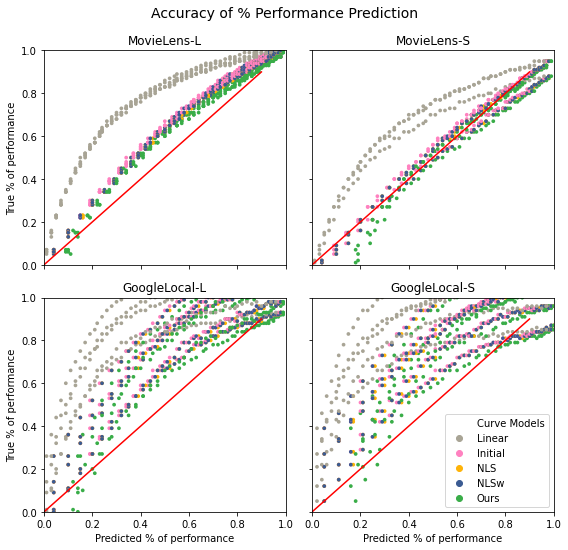

In [461]:
expmts = [('ml-20m-uniform', ml_expmt), ('ml-20m-tiny', mltiny_expmt), ('gl', gl_expmt), ('gl-tiny', gltiny_expmt)]
with sns.xkcd_palette(["greyish", "pink", "amber", "denim blue", "medium green"]):
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 8))

    for i, (dataset_name, _) in enumerate(expmts):
        ax = axs[int(i/2), i%2]
        hue_order = ['Linear', 'NLS_initial', 'NLS', 'NLS_w', 'NLS_mix']
        results_df = pd.read_csv('../results/forecasting/' + dataset_name + '/pred_performance')
        results_df = results_df.round({'pred_pct': 2, 'true_pct': 2})
        cm_results = results_df[results_df['cm'] != 'True']
        sns.scatterplot(x='pred_pct', y='true_pct', data=cm_results, hue='cm', hue_order=hue_order, s=14,
                         linewidth=0, ax=ax)
        ax.plot([i for i in np.arange(0, 1, .1)], [i for i in np.arange(0, 1, .1)], c='r', label='True')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_ylabel("True % of performance")
        ax.set_xlabel("Predicted % of performance")
        if i != 3:
            ax.get_legend().remove()
        else:
            L=ax.get_legend()
            new_names = ['Curve Models', 'Linear', 'Initial', 'NLS', 'NLSw', 'Ours']
            for i,new in enumerate(new_names):
                L.get_texts()[i].set_text(new)
        ax.set_title(dataset_titles[dataset_name])
plt.suptitle("Accuracy of % Performance Prediction", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../figs/performance_pred.png')

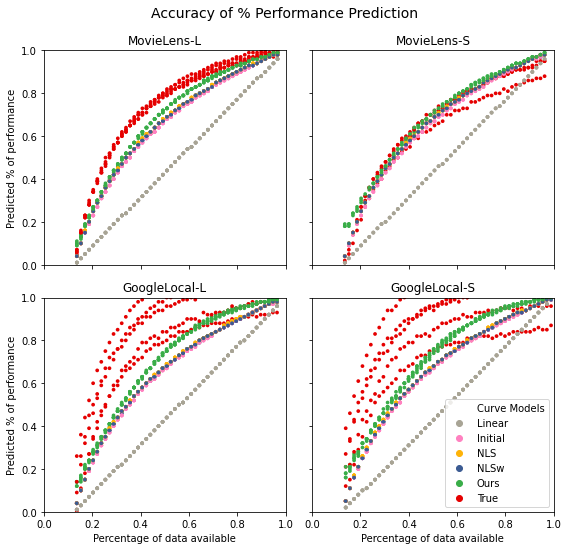

In [462]:
expmts = [('ml-20m-uniform', ml_expmt), ('ml-20m-tiny', mltiny_expmt), ('gl', gl_expmt), ('gl-tiny', gltiny_expmt)]
with sns.xkcd_palette(["greyish", "pink", "amber", "denim blue", "medium green", "red"]):
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 8))

    for i, (dataset_name, _) in enumerate(expmts):
        ax = axs[int(i/2), i%2]
        hue_order = ['Linear', 'NLS_initial', 'NLS', 'NLS_w', 'NLS_mix', 'True']
        results_df = pd.read_csv('../results/forecasting/' + dataset_name + '/pred_performance')
        results_df = results_df.round({'pred_pct': 2, 'true_pct': 2})
        #cm_results = results_df[results_df['cm'] != 'True']
        sns.scatterplot(x='pct_available', y='pred_pct', data=results_df, hue='cm', hue_order=hue_order, s=14,
                          linewidth=0, ax=ax)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_ylabel("Predicted % of performance")
        ax.set_xlabel("Percentage of data available")
        if i != 3:
            ax.get_legend().remove()
        else:
            L=ax.get_legend()
            new_names = ['Curve Models', 'Linear', 'Initial', 'NLS', 'NLSw', 'Ours']
            for i,new in enumerate(new_names):
                L.get_texts()[i].set_text(new)
        ax.set_title(dataset_titles[dataset_name])
plt.suptitle("Accuracy of % Performance Prediction", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../figs/performance_pred_v_pct_available.png')

(100000.0, 160000.0)

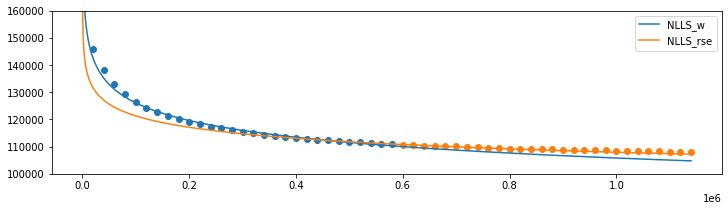

In [85]:
fig= plt.figure(figsize=(12,3))
plt.scatter(ss[:train_pt], mses[:train_pt])
plt.scatter(ss[train_pt:], mses[train_pt:])

plt.plot(x_samples, nlls_w_y, label="NLLS_w")
plt.plot(x_samples, nlls_rse_y, label="NLLS_rse")
plt.legend()
plt.ylim(100000, 160000)
# plot the best mse
# plot the worst mse
# plot 

In [230]:
# Calculate predicted percentage based on fully fit curve
# Fit curves based on that amount of data, predict for n_init, n_available, n_total
# Get real percentage using validation MSE, worst_mse, and best_mse


pred_worsts, pred_bests, pred_currs = [], [], []
true_mses = []
for i, (size, mse) in enumerate(zip(ss, mses)):
    if size < n_init:
        continue
    # Fit curve for all points in ss and mses through pt i
    
    # Calculate true percentage of total performance
    true_pct = (worst_mse - mse)/(worst_mse - best_mse)
    pred_pcts.append(pred_pct)
    true_pcts.append(true_pct)
    pred_worsts.append(pred_worst)
    pred_bests.append(pred_best)
    pred_currs.append(pred_curr)
    true_mses.append(mse)
    

(120000.0, 123000.0)

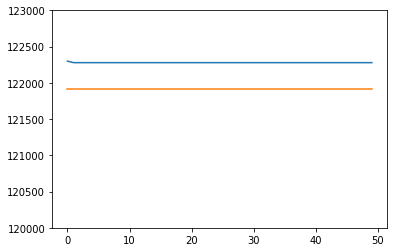

In [231]:
plt.plot(np.arange(len(pred_worsts)), pred_worsts )
plt.plot(np.arange(len(pred_worsts)), [worst_mse for i in range(len(pred_worsts))] )

# plt.plot(np.arange(len(pred_worsts)), pred_bests )
# plt.plot(np.arange(len(pred_worsts)), [best_mse for i in range(len(pred_worsts))] )

# plt.plot(np.arange(len(pred_worsts)), pred_currs )
# plt.plot(np.arange(len(pred_worsts)), true_mses )
plt.ylim(120000, 123000)

(0.1, 0.9)

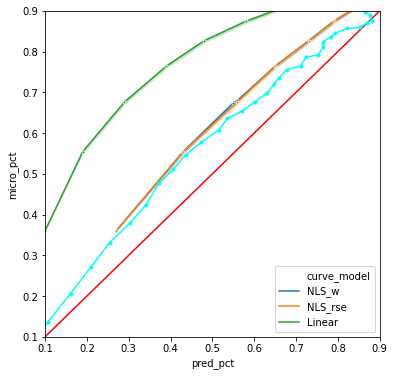

In [234]:
fig= plt.figure(figsize=(6,6))
data = data.round({'pred_pct': 2, 'micro_pct': 2, 'pct_available': 2})
sns.lineplot(x='pred_pct', y='micro_pct', hue='curve_model', data=data[data['curve_model'] != 'Initial'], marker='.')
plt.plot([i for i in np.arange(.1, 1, .1)], [i for i in np.arange(.1, 1, .1)], c='r')
plt.plot(pred_pcts, true_pcts, c='cyan', marker='.')
plt.ylim(.1, .9)
plt.xlim(.1, .9)

In [154]:
old_pred_pcts = pred_pcts.copy()

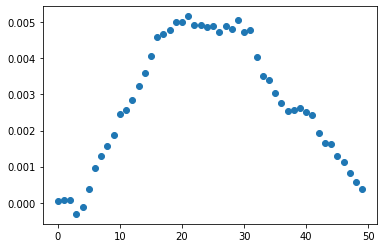

In [162]:
plt.scatter(np.arange(len(pred_pcts)), np.array(old_pred_pcts) - np.array(pred_pcts))